# Model Pipeline and Evaluation

In [0]:
local = False

In [3]:
# Install the OpenSlide C library and Python bindings
if not local:
    !apt-get install openslide-tools
    !pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (125 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [4]:
if not local:
    %tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pickle
import random
import time
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib.gridspec as gridspec
import matplotlib.patches as mp_patches

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
from sklearn import metrics
from matplotlib import gridspec
from matplotlib.colors import Normalize
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if not local:
  folder_root = "/content/drive/My Drive/4995-final"
  slides_folder = os.path.join(folder_root, 'slides')
else:
  folder_root = '.'
  slides_folder = '.'

In [0]:
if not os.path.exists(folder_root):
  os.mkdir(folder_root)

if not os.path.exists(slides_folder):
  os.mkdir(slides_folder)

## Slide Related Functions

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
  im = slide.read_region((x,y), level, (width, height))
  im = im.convert('RGB') # drop the alpha channel
  if as_float:
      im = np.asarray(im, dtype=np.float32)
  else:
      im = np.asarray(im)
  assert im.shape == (height, width, 3)
  return im

# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def create_tissue_mask(im, mask, color=(1,1,1)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

def get_downsample_ratio(level):
  return 2**level

# Patch Extraction Utilities

In [0]:
def is_patch_tumor(mask, patch_center):
  """Check if the patch within patch_center x patch_center contains tumor
  
  mask: the tumor mask
  patch_center: the patch centroid and size
  """
  y = int(round(mask.shape[0]/2)) - int(round(patch_center/2))
  x = int(round(mask.shape[1]/2)) - int(round(patch_center/2))
  center_region = mask[y:y+patch_center, x:x+patch_center]

  return np.sum(center_region) > 0

def get_dim_from_slide(slide, lvl):
  """Get the dimension of a level

  slide: a slide image
  lvl: a level
  """
  return int(slide.level_downsamples[lvl])

def extract_patches_only_from_center(x, y, slide, tumor_mask, lvl, patch_size):
  """Extract slide and tumor patches.

  x: x-axis center
  y: y-axis center
  slide: the full image slide
  tumor_mask: the full tumor mask slide
  lvl: zoom level
  patch_size: the size of the patch
  """
  dim = get_dim_from_slide(slide, lvl)
    
  # extract slide image by patch_size x patch_size centered at patch_center x patch_center size
  slide_patch = read_slide(
    slide, 
    x=(x - patch_size//2)*dim, 
    y=(y - patch_size//2)*dim,
    level=lvl, 
    width=patch_size, 
    height=patch_size
  )

  # extract tumor by patch_size x patch_size centered at patch_center x patch_center size
  tumor_patch = read_slide(
      tumor_mask, 
      x=(x - patch_size//2)*dim, 
      y=(y - patch_size//2)*dim,
      level=lvl, 
      width=patch_size, 
      height=patch_size
  )

  # tumor patch just use one channel
  tumor_patch = tumor_patch[:, :, 0]

  return slide_patch, tumor_patch

def extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size):
  """Extract slide, tumor and tissue regions

  x: x-axis center
  y: y-axis center
  slide: the full image slide
  tumor_mask: the full tumor mask slide
  lvl: zoom level
  patch_size: the size of the patch
  """
  slide_patch, tumor_patch = extract_patches_only_from_center(x, y, slide, 
                                                              tumor_mask, lvl, patch_size)
  
  # extract tissue pixels
  tissue_pixels = find_tissue_pixels(slide_patch)
  percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100
  
  return slide_patch, tumor_patch, tissue_pixels, percent_tissue

def extract_patches(slide, tumor_mask, lvl, patch_center=128, patch_size=299, 
                    max_patches=100, plot_patch=False, healthy_ratio=0.6):
  """Extract slide and tumor patches and labels to build the training data for a slide

  slide: slide for the image
  tumor mask: slide for the mask
  lvl: zoom level
  max_patches: how many patches to extract
  plot_patch: boolean to indicate plotting the image
  healthy_ratio: the ratio between healthy and tumor patches
  """
  print("===Start Extracting patches..===")
  start_time = time.time() / 60
  data_patches, data_masks, data_labels, data_tissues = [], [], [], []
  
  # number of possible patches
  dim = int(tumor_mask.level_downsamples[lvl])
  
  # extract full patch
  slide_image = read_slide(
    slide, 
    x=0, 
    y=0,
    level=lvl, 
    width=slide.level_dimensions[lvl][0], 
    height=slide.level_dimensions[lvl][1]
  )
  
  # extract tumor patches
  tumor_image = read_slide(
    tumor_mask, 
    x=0, 
    y=0,
    level=lvl, 
    width=tumor_mask.level_dimensions[lvl][0], 
    height=tumor_mask.level_dimensions[lvl][1]
  )
  # tumor patch just use one channel
  tumor_image = tumor_image[:,:,0]
  
  # check if it's a tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_masked = create_tissue_mask(slide_image, tissue_pixels)

  tissue_healthy = tissue_masked[:,:,0] - tumor_image
  tissue_healthy[tissue_healthy < 0] = 0
  
  # extract tumorous patches, returns indexes (arr[y], arr[x])
  tissue_tumor_idx = np.where(tumor_image > 0)
  
  # extract healthy patches, returns indexes (arr[y], arr[x])
  tissue_healthy_idx = np.where(tissue_healthy > 0)
  
  print("#tumorous tissue pixels: {}, #healthy tissue pixels: {}".format(
    len(tissue_tumor_idx[0]),
    len(tissue_healthy_idx[0]),
  ))
  
  # sample from tumor pixels (x, y)
  max_tumor = int(max_patches * (1 - healthy_ratio))
  tumor_pixels = random.sample(list(zip(tissue_tumor_idx[1], tissue_tumor_idx[0])), 
                                min(1000, len(tissue_tumor_idx[0]) // 2))
  
  # sample from healthy pixels (x, y)
  max_healthy = int(max_patches * healthy_ratio)
  healthy_pixels = random.sample(list(zip(tissue_healthy_idx[1], tissue_healthy_idx[0])), 
                                  min(5000, len(tissue_healthy_idx[0]) // 2))
  
  # extract tumor patches
  count_tumor = 0
  while len(tumor_pixels) != 0 and count_tumor < max_tumor:
    (x, y) = tumor_pixels.pop()
      
    # extract center patches
    slide_patch, tumor_patch, tissue_patch, percent_tissue = \
      extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size)
      
    # add to healthy if it's not a tumor
    if percent_tissue > 50 and is_patch_tumor(tumor_patch, patch_center):
      data_patches.append(slide_patch)
      data_masks.append(tumor_patch)
      data_labels.append(1)
      
      count_tumor += 1
  
  # extract healthy patches
  count_healthy = 0
  while len(healthy_pixels) != 0 and count_healthy < max_healthy:
    (x, y) = healthy_pixels.pop()
    
    # extract center patches
    slide_patch, tumor_patch, tissue_patch, percent_tissue = \
        extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size)

    # check if it's a tissue pixels
    tissue_pixels = find_tissue_pixels(slide_patch)
    percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100
    
    # add to healthy if it's not a tumor
    if percent_tissue > 50 and not is_patch_tumor(tumor_patch, patch_center):
      data_patches.append(slide_patch)
      data_masks.append(tumor_patch)
      data_labels.append(0)
      
      count_healthy += 1
  
  print("Tumor Patches: {}, Healthy Patches: {}".format(count_tumor, count_healthy))
  data_patches, data_masks, data_labels = (
    np.array(data_patches), 
    np.array(data_masks), 
    np.array(data_labels)
  )
  extraction_time = time.time()/60 - start_time
  
  if plot_patch:
    # plot images
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes[0].imshow(slide_image)
    axes[0].set_title("full slide")

    axes[1].imshow(tumor_image)
    axes[1].set_title("full tumor mask")

    axes[2].imshow(tissue_healthy)
    axes[2].set_title("full healthy tissue")

    axes[3].imshow(slide_image)
    axes[3].imshow(np.ma.masked_values(tumor_image, 0), 
                    cmap='viridis', vmin=0, vmax=1, alpha=0.8)
    axes[3].set_title("full tumor on slide")
      
  print('Time: %.2f min' % extraction_time)
  print("===Patch Extraction Done!===")
  
  return data_patches, data_masks, data_labels

def extract_patches_from_slide_id(slide_id, level, max_patches=200, force_reload=False):
  slide = open_slide(os.path.join(slides_folder, "tumor_{}.tif".format(slide_id)))
  tumor_mask = open_slide(os.path.join(slides_folder, "tumor_{}_mask.tif".format(slide_id)))
  
  data_dir = 'preprocessed'
  data_dir_path = os.path.join(folder_root, data_dir)
  
  print("======Start Extracting Patch ID {} Level {}======".format(slide_id, level))
  start_time = time.time()
  
  if not os.path.exists(data_dir_path):
    print("{} does not exist! Creating a directory...".format(data_dir_path))
    os.mkdir(data_dir_path)
      
  patch_path = os.path.join(data_dir_path, "patch_{}_lvl_{}.npy".format(slide_id, level))
  mask_path = os.path.join(data_dir_path, "mask_{}_lvl_{}.npy".format(slide_id, level))
  label_path = os.path.join(data_dir_path, "labels_{}_lvl_{}.npy".format(slide_id, level))
  
  if not os.path.exists(patch_path) or \
    not os.path.exists(mask_path) or \
    not os.path.exists(label_path) or \
    force_reload:
    print("Preprocessing data...")
    data_patches, data_masks, data_labels = extract_patches(slide, tumor_mask, 
                                                            level, max_patches=max_patches)
    
    np.save(patch_path, data_patches)
    print("Wrote to {}".format(patch_path))
    np.save(mask_path, data_masks)
    print("Wrote to {}".format(mask_path))
    np.save(label_path, data_labels)
    print("Wrote to {}".format(label_path))
  else:
    print("Data already exists! Preload existing data...")
    data_patches = np.load(patch_path)
    data_masks = np.load(mask_path)
    data_labels = np.load(label_path)
    print("Total tumors: {}".format(data_labels.sum()))
  
  patch_ext_time = (time.time() - start_time)/60
  print('Time: %.2f min' % patch_ext_time)
  print("======Finish Extracting Patch ID {} Level {}======".format(slide_id, level))
      
  return data_patches, data_masks, data_labels

In [0]:
# Sanity Check: check extracted patches

#From left to right, we show slide, tumor mask and slide plus tumor mask. For the tumor mask on slide,
#we show the centre with red square.
#if there is no tumor at the center we label it 0
#if there is tumor at the center we label it 1.

def plot_sample_patches(patches, masks, N=4, patch_center=128, patch_size=299):
  """Plot sample patches
  patches: the patches
  masks: the masks
  """
  rand_indices = []
  rand_indices.extend(np.random.choice(np.where(labels == 0)[0], N//2, replace=False))
  rand_indices.extend(np.random.choice(np.where(labels == 1)[0], N//2, replace=False))

  fig = plt.figure(figsize=(15/4*N, 15/4*N))
  gs = gridspec.GridSpec(N, 3)

  for i in range(N):
    idx = rand_indices[i]

    # plotting the 128x128 center
    offset = int((patch_size - patch_center)/2)

    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(patches[idx])
    ax.set_title("slide")
    ax.set_ylabel("Label: {}".format(labels[idx]))

    ax = fig.add_subplot(gs[i, 1])
    ax.imshow(masks[idx])
    ax.set_title("tumor mask")

    ax = fig.add_subplot(gs[i, 2])
    ax.imshow(patches[idx])
    ax.imshow(np.ma.masked_values(masks[idx], 0), 
              cmap='viridis', vmin=0, vmax=1, alpha=0.8)
    rect = mp_patches.Rectangle(
        (int((patch_size - patch_center)/2), int((patch_size - patch_center)/2)),
        patch_center, patch_center, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.set_title("tumor mask on slide")

# Data Loading and Splitting

This loads the processed data done in the previous part, and split the data into
3 sets: training, validation and testing

In [0]:
def load_all_slides(level_dir, train_ids, test_ids):
  """This method loads several preprocessed slide images, tumors and labels
  within the same zoom level used to speed up for experimentations and 
  exploring models and evaluations

  level_dir: the directory of the slide images at level x
  train_ids: the list of slide ids for training data
  test_ids: the list of slide ids for test data
  """
  files = os.listdir(level_dir)

  # map id to patch, mask, labels, record
  all_files = { }

  for f in files:
    fn = f.split("_")
    dtype, slide_id = fn[0], fn[1]
    data = np.load(os.path.join(level_dir, f))
    
    if slide_id in all_files:
      slide_data = all_files[slide_id]
      slide_data[dtype] = data
    else:
      all_files[slide_id] = {}
      all_files[slide_id][dtype] = data

  train_patches, train_masks, train_labels, train_slide_ids = [], [], [], []
  test_patches, test_masks, test_labels, test_slide_ids = [], [], [], []

  for slide_id in all_files.keys():
    N = len(all_files[slide_id]['patch'])
    assert N == len(all_files[slide_id]['mask'])
    assert N == len(all_files[slide_id]['labels'])

    if slide_id in train_ids:
      train_patches.extend(all_files[slide_id]['patch'])
      train_masks.extend(all_files[slide_id]['mask'])
      train_labels.extend(all_files[slide_id]['labels'])
      train_slide_ids.extend([slide_id]*N)
    elif slide_id in test_ids:
      test_patches.extend(all_files[slide_id]['patch'])
      test_masks.extend(all_files[slide_id]['mask'])
      test_labels.extend(all_files[slide_id]['labels'])
      test_slide_ids.extend([slide_id]*N)

  return (np.array(train_patches), np.array(train_masks), 
          np.array(train_labels), np.array(train_slide_ids),
          np.array(test_patches), np.array(test_masks),
          np.array(test_labels), np.array(test_slide_ids))

# Experiment Definitions

In [0]:
LEVEL_DIR = "/content/drive/My Drive/level_4"
SLIDE_DIR = "/content/drive/My Drive/slides_copy"
MODEL_TAG = "lvl4-all"
LEVEL = 4

# Load All the Saved Slides

In [0]:
good_slides = ['016', '019', '023', '031', '057', '064', '075', 
               '078', '084']

# generate random training and testing ids
# num_test = 3
# train_ids = np.random.choice(good_slides, len(good_slides) - num_test, replace=False)
# test_ids = list(set(good_slides) - set(train_ids))
# print("Train: {}, Test: {}".format(train_ids, test_ids))

train_ids = ['016', '064', '031', '075','078', '084', '094', '096', '101']
test_ids = ['001', '005', '091']

In [0]:
(train_patches, train_masks, train_labels, train_slide_ids,
    test_patches, test_masks, test_labels, test_slide_ids) = \
    load_all_slides(LEVEL_DIR, train_ids, test_ids)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [0]:
X_train, X_val, y_train, y_val = train_test_split(np.array(train_patches), 
                                                  np.array(train_labels), 
                                                  test_size=0.33)

## Modelling

## Model Definitions

In [0]:
def create_model(base='vgg'):
    model = tf.keras.Sequential()
    if base == 'vgg':
      conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                              include_top=False,
                                              input_shape=(299, 299, 3))
    elif base == "inception":
      conv_base = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                                                 include_top=False,
                                                                 input_shape=(patch_size, patch_size, 3))

    conv_base.trainable = False
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
  
    return model

In [0]:
# All images will be rescaled by 1./255

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# Create data generators
train_generator = train_datagen.flow(
    X_train, 
    y_train, 
    batch_size=32, 
    shuffle=True)

val_generator = test_datagen.flow(
    X_val, 
    y_val, 
    batch_size=32, 
    shuffle=True)

In [0]:
# Load the latest model if available
def load_latest_checkpoint(model_tag):
  """Loads the 'best' latest model for that model tag if it exists.

  model_tag: the model id
  """
  try:
    model_dir = os.path.join(folder_root, "models")
    model_path = os.path.join(model_dir, 'model_{tag}.h5'.format(tag=model_tag))

    if os.path.exists(model_path):
      print("Loading model and weights")
      model = tf.keras.models.load_model(model_path)
    
      checkpoint_path = os.path.join(folder_root, 
                                    'checkpoints-{tag}'.format(tag=model_tag))
      latest = tf.train.latest_checkpoint(checkpoint_path)

      if latest != None:
        print("Loading weights from", latest)
        model.load_weights(latest)
        
        history = None

        history_dir = os.path.join(folder_root, 'history')
        history_path = os.path.join(history_dir, "model_{tag}.pkl".format(tag=model_tag))

        if os.path.exists(history_path):
          with open(history_path, 'rb') as fp:
            history = pickle.load(fp)

        return model, history
    else:
      print("Checkpoint not found. Starting from scratch")
  except ValueError:
      pass
    
  return None, None

def load_latest_model(model_tag):
  """Loads the last model trained for that model_tag if it exists.

  model_tag: the model id
  """
  try:
    model_dir = os.path.join(folder_root, "models")
    model_path = os.path.join(model_dir, 'model_{tag}.h5'.format(tag=model_tag))

    if os.path.exists(model_path):
      print("Loading model and weights")
      model = tf.keras.models.load_model(model_path)
      
      history = None

      history_dir = os.path.join(folder_root, 'history')
      history_path = os.path.join(history_dir, "model_{tag}.pkl".format(tag=model_tag))

      if os.path.exists(history_path):
        with open(history_path, 'rb') as fp:
          history = pickle.load(fp)

      return model, history
    else:
      print("Checkpoint not found. Starting from scratch")
  except ValueError:
      pass
  
  return None, None

In [0]:
def train_model(model, train_data_gen, val_data_gen, epochs, model_tag):
  """Train a CNN model for slide patches and corresponding labels. This method
  will perform checkpointings (by saving the best weights) and utilize early 
  stop mechanism to stop the training when the model doesn't improve. 

  model: a CNN model
  epochs: number of epochs
  model_tag: the model ID
  """
  # time model run
  start_time = time.time()/60

  # checkpoints dir
  checkpoints_dir = 'checkpoints-{tag}'.format(tag=model_tag)
  checkpoints_dir_path = os.path.join(folder_root, checkpoints_dir)

  if not os.path.exists(checkpoints_dir_path):
    os.mkdir(checkpoints_dir_path)

  # history dir
  history_dir = 'history'.format(tag=model_tag)
  history_dir_path = os.path.join(folder_root, history_dir)

  if not os.path.exists(history_dir_path):
    os.mkdir(history_dir_path)

  # models dir
  models_dir = 'models'
  models_dir_path = os.path.join(folder_root, models_dir)

  if not os.path.exists(models_dir_path):
    os.mkdir(models_dir_path)

  checkpoint_path = os.path.join(checkpoints_dir_path, 'cp-{epoch:08d}.ckpt')
  print("Checkpoint path: {}".format(checkpoint_path))

  # save checkpoints
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                       min_delta=0.001,
                                       patience=10,
                                       verbose=1),
      tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path,
          # Path where to save the model
          # The two parameters below mean that we will overwrite
          # the current checkpoint if and only if
          # the `val_loss` score has improved.
          save_best_only=True,
          save_weights_only=True,
          monitor='val_loss',
          verbose=1)
  ]

  history = model.fit_generator(
      train_data_gen,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks)

  # save model to drive
  model_filename = "model_{tag}.h5".format(tag=model_tag)
  model_path = os.path.join(models_dir_path, model_filename)
  
  print("Saved model to: {}".format(model_path))
  model.save(model_path)

  history_path = os.path.join(history_dir_path, 'model_{tag}.pkl'.format(tag=model_tag))
  with open(history_path, "wb") as fp:
      pickle.dump(history.history, fp)

  train_time = time.time()/60 - start_time
  print('Time: %.2f min' % train_time)

  return model, history

In [0]:
import matplotlib.pyplot as plt

def plot_model_history(history):
  acc = history['acc']
  val_acc = history['val_acc']
  loss = history['loss']
  val_loss = history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

## Model Training

In [24]:
model = create_model()
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

58892288/58889256 [==============================] - 2s 0us/step


In [25]:
model, history = train_model(model, train_generator, val_generator, 
                             epochs=50, model_tag=MODEL_TAG)

Checkpoint path: /content/drive/My Drive/4995-final/checkpoints-lvl4-all/cp-{epoch:08d}.ckpt
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 13 steps
Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 2.0245 - acc: 0.6026
Epoch 00001: val_loss improved from inf to 0.45336, saving model to /content/drive/My Drive/4995-final/checkpoints-lvl4-all/cp-00000001.ckpt
26/26 [==============================] - 15s 583ms/step - loss: 1.9922 - acc: 0.6022 - val_loss: 0.4534 - val_acc: 0.8025
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 0.4771 - acc: 0.7756
Epoch 00002: val_loss improved from 0.45336 to 0.35876, saving model to /content/drive/My Drive/4995-final/checkpoints-lvl4-all/cp-00000002.ckpt
26/26 [==============================] - 7s 277ms/step - loss: 0.4712 - acc: 0.7771 - val_loss: 0.3588 - val_acc: 0.8475
Epoch 3/50
25/26 [==============

In [26]:
model, history = load_latest_checkpoint(MODEL_TAG)

Loading model and weights
Loading weights from /content/drive/My Drive/4995-final/checkpoints-lvl4-all/cp-00000013.ckpt


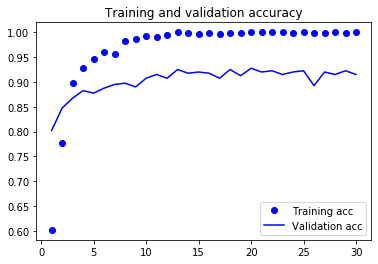

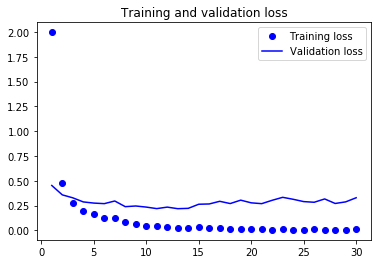

In [27]:
plot_model_history(history)

## Model Prediction

In [0]:
# simple heatmap using the same image
# split regions into 299x299, predict if center is tumor --> color the region with yellow
def extract_test_data(slide, tumor_mask, lvl, patch_center=128, patch_size=299):
  """Extract the whole test patches from a slide at a level

  slide: the slide for image
  tumor_mask: the slide for tumor
  lvl: the zoom level
  patch_center: the patch center and center's pixel size
  patch_size: the patch size
  """
  print("===Start Extracting patches for Testing..===")
  start_time = time.time() / 60
  dim = get_dim_from_slide(slide, lvl)

  test_coords = []
  test_patches = []
  true_labels = []

  count = 0
  
  for y in range(0, slide.level_dimensions[lvl][1], patch_center):
    for x in range(0, slide.level_dimensions[lvl][0], patch_center):
        # extract slide image by patch_size x patch_size centered at patch_center x patch_center size
        slide_patch = read_slide(
            slide, 
            x=(x + int(round(patch_center / 2)) - int(round(patch_size/2)))*dim, 
            y=(y + int(round(patch_center / 2)) - int(round(patch_size/2)))*dim,
            level=lvl, 
            width=patch_size, 
            height=patch_size
        )
        
        # extract tumor by patch_size x patch_size centered at patch_center x patch_center size
        tumor_patch = read_slide(
            tumor_mask, 
            x=(x + int(round(patch_center / 2)) - int(round(patch_size/2)))*dim, 
            y=(y + int(round(patch_center / 2)) - int(round(patch_size/2)))*dim,
            level=lvl, 
            width=patch_size, 
            height=patch_size
        )
        # tumor patch just use one channel
        tumor_patch = tumor_patch[:, :, 0]
        
        # check if it's a tissue pixels
        tissue_pixels = find_tissue_pixels(slide_patch)
        percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100
        
        if percent_tissue > 10:
            test_coords.append((y, x))
          
            test_patches.append(slide_patch)
            label = is_patch_tumor(tumor_patch, patch_center)
            true_labels.append(int(label))

            count += 1

  test_coords = np.array(test_coords)
  test_patches = np.array(test_patches)
  true_labels = np.array(true_labels)

  patch_ext_time = time.time()/60 - start_time

  print("Extracted {} patches".format(len(true_labels)))
  print('Time: %.2f min' % patch_ext_time)
  print("===Finsihed Extracting patches for Testing..===")

  return test_coords, test_patches, true_labels

In [0]:
def predict_test_data(model, test_datagen, test_patches, true_labels):
  test_generator = test_datagen.flow(
    test_patches, 
    true_labels,
    batch_size=32, 
    shuffle=False
  )
  
  # predict test_patches
  pred_labels = model.predict(test_generator)
  pred_labels = pred_labels.ravel()

  return pred_labels

# Testing and Evaluation

In [0]:
def evaluate_prediction(true_labels, pred_labels):
  # calculate roc, auc score and average precision on predicted probabilities
  roc_auc = metrics.roc_auc_score(true_labels == 1, pred_labels)
  avg_precision = metrics.average_precision_score(true_labels == 1, pred_labels)

  # calculate f1, recall, and precision scores on the predicted labels (0 or 1)
  precision = metrics.precision_score(true_labels == 1, pred_labels > 0.5)
  recall = metrics.recall_score(true_labels == 1, pred_labels > 0.5)
  f1 = metrics.f1_score(true_labels == 1, pred_labels > 0.5)

  print("===Evaluation Metrics===")
  print('Precision score: %.3f' % precision)
  print('Recall score: %.3f' % recall)
  print('F1 score: %.3f' % f1)
  print('ROC AUC score: %.3f' % roc_auc)
  print('Average precision score: %.3f' % avg_precision)

In [0]:
def plot_prob_heatmap(pred_labels, slide, tumor_mask, lvl, coords, patch_center=128):
  """Plot the probability heatmap on the slide

  pred_labels: the predicted probability
  slide: the cell tissue slide
  tumor_mask: the tumor mask slide
  lvl: the zoom level
  coords: the coordinates of the cells
  patch_center: the patch center
  """
  slide_image = read_slide(
      slide,
      x=0, 
      y=0, 
      level=lvl,
      width=slide.level_dimensions[lvl][0],
      height=slide.level_dimensions[lvl][1]
  )

  slide_tumor = read_slide(
      tumor_mask,
      x=0, 
      y=0, 
      level=lvl,
      width=slide.level_dimensions[lvl][0],
      height=slide.level_dimensions[lvl][1]
  )
  slide_tumor = slide_tumor[:,:,0]

  # Src: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_transparency_blend.html
  hm_overlay = np.zeros(
      (slide.level_dimensions[lvl][1], slide.level_dimensions[lvl][0])
  )
  for idx in range(len(coords)):
    y, x = coords[idx]
    hm_overlay[y:y+patch_center, x:x+patch_center] = pred_labels[idx]

  # First we'll plot these blobs using only ``imshow``.
  vmax = np.abs(hm_overlay).max()
  vmin = 0
  cmap = plt.cm.inferno

  # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
  colors = Normalize(vmin, vmax, clip=True)(hm_overlay)
  colors = cmap(colors)

  # 1 being opaque, 0 being transparent
  # Now set the alpha channel to the one we created above
  colors[..., -1] = hm_overlay/np.max(hm_overlay)

  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  axes[0].imshow(slide_image)
  axes[0].imshow(np.ma.masked_values(slide_tumor, 0), 
                 cmap=cmap, vmin=0, vmax=1, alpha=0.8)

  axes[1].imshow(slide_image)
  axes[1].imshow(colors, vmin=vmin, vmax=vmax, cmap=cmap)

In [32]:
test_ids

['001', '005', '091']

In [0]:
def evaluate_model_on_slide(model, slide_id):
  slide_path = os.path.join(SLIDE_DIR, 
                          "Copy of tumor_{id}.tif".format(
                              id=slide_id
                          ))

  tumor_path = os.path.join(SLIDE_DIR, 
                            "Copy of tumor_{id}_mask.tif".format(
                                id=slide_id
                            ))

  slide_image = open_slide(slide_path)
  slide_tumor = open_slide(tumor_path)

  test_coords, test_patches, true_labels = extract_test_data(slide_image, 
                                                             slide_tumor, 
                                                             LEVEL, 
                                                             patch_center=128, 
                                                             patch_size=299)
   
  pred_labels = predict_test_data(model, test_datagen, test_patches, true_labels)
  
  evaluate_prediction(true_labels, pred_labels)
  plot_prob_heatmap(pred_labels, slide_image, slide_tumor, LEVEL, test_coords)

In [34]:
model, history = load_latest_checkpoint(MODEL_TAG)

Loading model and weights
Loading weights from /content/drive/My Drive/4995-final/checkpoints-lvl4-all/cp-00000013.ckpt


===Start Extracting patches for Testing..===
Extracted 1221 patches
Time: 0.80 min
===Finsihed Extracting patches for Testing..===
===Evaluation Metrics===
Precision score: 0.067
Recall score: 0.545
F1 score: 0.119
ROC AUC score: 0.923
Average precision score: 0.067


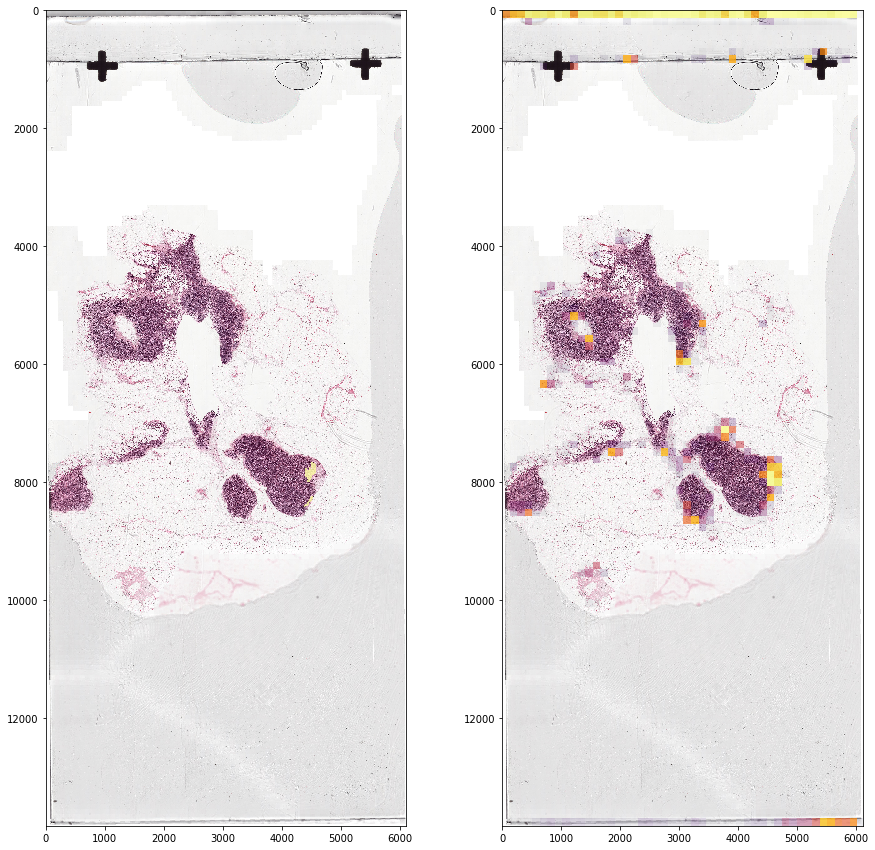

In [35]:
evaluate_model_on_slide(model, test_ids[0])

===Start Extracting patches for Testing..===
Extracted 694 patches
Time: 0.71 min
===Finsihed Extracting patches for Testing..===
===Evaluation Metrics===
Precision score: 0.443
Recall score: 0.712
F1 score: 0.547
ROC AUC score: 0.889
Average precision score: 0.626


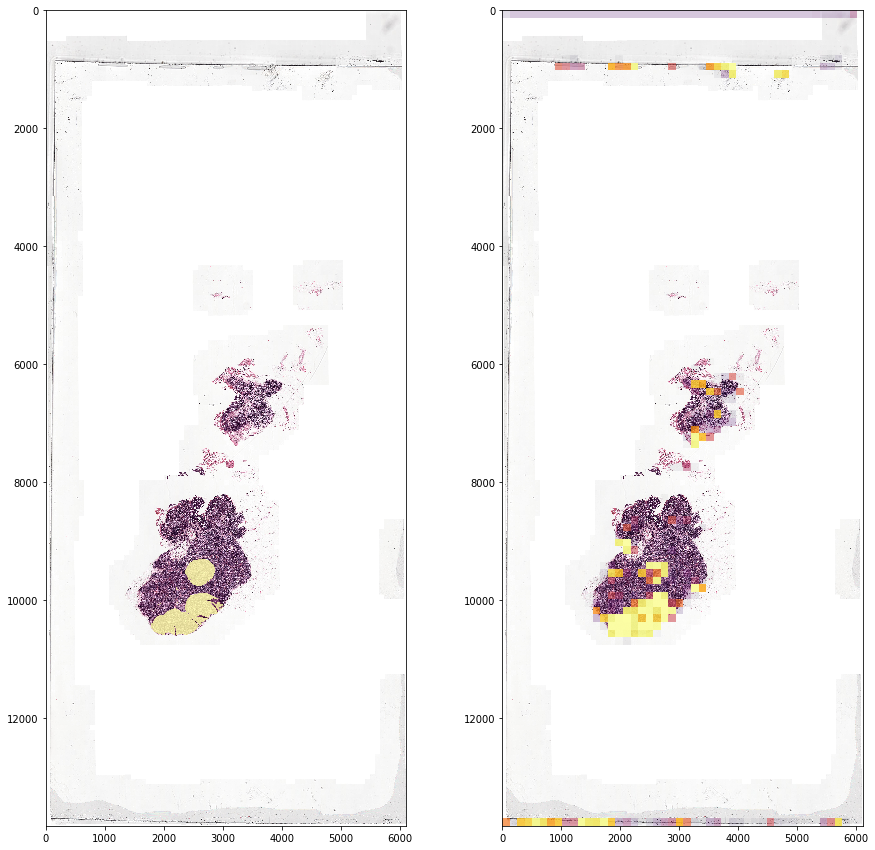

In [36]:
evaluate_model_on_slide(model, '016')

===Start Extracting patches for Testing..===
Extracted 568 patches
Time: 0.69 min
===Finsihed Extracting patches for Testing..===
===Evaluation Metrics===
Precision score: 0.646
Recall score: 0.616
F1 score: 0.631
ROC AUC score: 0.896
Average precision score: 0.727


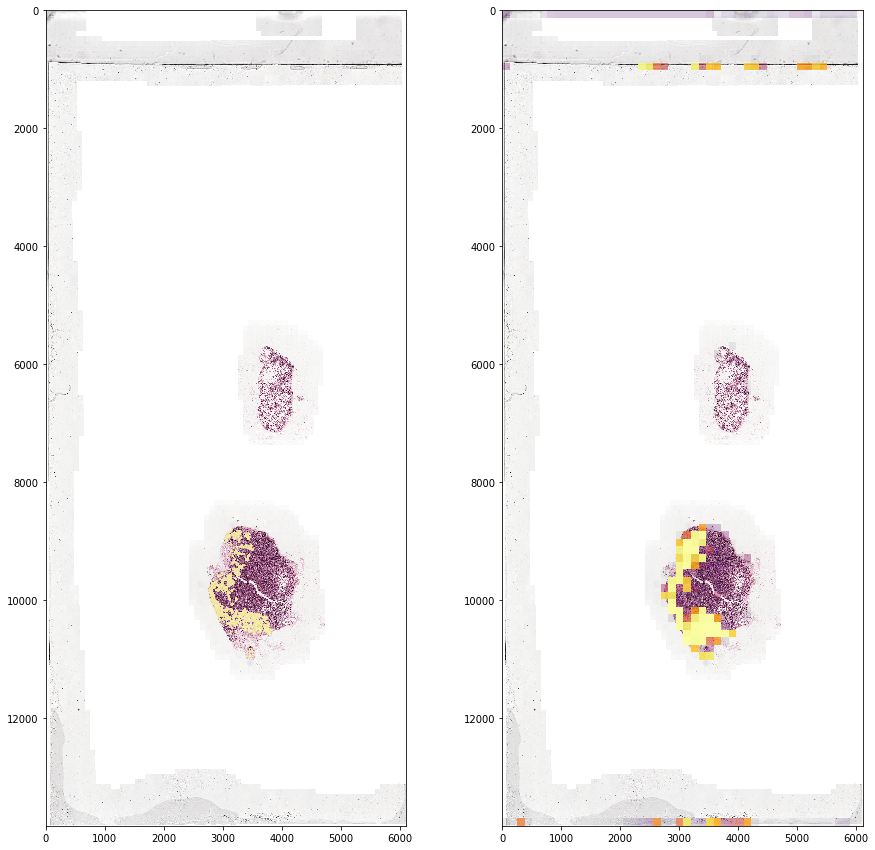

In [37]:
evaluate_model_on_slide(model, '101')